# Testing TRICERATOPS EB modeling vs. **isochrones**

We want to test how the luminosity-scaling method compares to physical modeling based on colors & parallax.

This is the layout of the test:

1.  Choose arbitrary properties for our test target star.
2.  Sample space of possible stellar binaries physically consistent with observed apparent V, K, and parallax.
3.  Compute f_EB for each sample--this gives a distribution of the true allowed distribution of f_EB.
4.  For each of these f_EB samples, compute the primary and secondary radius via the "luminosity scaling" method.
5.  Compare these comupted R1, R2 with the actual true primary and secondary radii from the samples. 

## Set properties of primary star

In [1]:
from isochrones import get_ichrone

mist = get_ichrone('mist', bands=['TESS', 'V', 'K'])

mass, age, feh = (0.8, 9.7, 0.0)
distance = 10  # pc
AV = 0.0

simulated_props = mist.generate(mass, age, feh, distance=distance, AV=AV)
simulated_props[['mass', 'radius', 'TESS_mag', 'V_mag', 'K_mag']]

,mass,radius,TESS_mag,V_mag,K_mag
0,0.799944,0.754529,5.350309,6.17266,4.075245


## Sample space of allowed binaries

In [2]:
from isochrones import BinaryStarModel

# set "observed" properties to the true simulated V, K, and parallax.  
props = {'V': (float(simulated_props['V_mag']), 0.02), 'K': (float(simulated_props['K_mag']), 0.02), 'parallax': (100, 0.05)}

mod = BinaryStarModel(mist, **props, maxAV=0.0001, eep_bounds=(0, 450), name='triceratops_eb_1')

In [3]:
mod.fit()

Let's check out the joint distribution of R1, R2 allowed by this sampling.

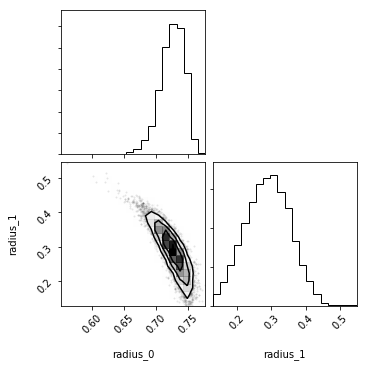

In [4]:
from corner import corner

corner(mod.derived_samples[['radius_0', 'radius_1']]);

## Compute $f_{EB}$ for each sample

The above sampling provides derived samples of the primary and secondary TESS mags.  This allows us to compute $f_{EB}$.  First note that
$$ f_{EB} = \frac{f_2}{f_1 + f_2} $$
From the magnitude difference `TESS_mag_1 - TESS_mag_0` we can compute the secondary/primary flux ratio $f_2/f_1$, and we can rewrite $f_{EB}$ as follows:
$$ f_{EB} = \frac{1}{\frac{f_1}{f_2} + 1} $$

In [5]:
dmag = mod.derived_samples['TESS_mag_1'] - mod.derived_samples['TESS_mag_0']
f_ratio = 10**(-0.4 * dmag)
f_EB = 1 / (1./f_ratio + 1)
f_EB.describe()

count    5434.000000
mean        0.034502
std         0.025674
min         0.001645
25%         0.016817
50%         0.029310
75%         0.046069
max         0.490022
dtype: float64

## Compute primary & secondary radii using TRICERATOPS method

In [6]:
from triceratops.funcs import stellar_relations

def get_radii(L, f_EB):
    L1 = L * (1 - f_EB)
    L2 = L * f_EB
    _, R1, _, _, _ = stellar_relations(lum=L1)
    _, R2, _, _, _ = stellar_relations(lum=L2)
    return R1, R2

R1, R2 = zip(*[get_radii(float(10**simulated_props['logL']), f) for f in f_EB])

## Compare derived R1, R2 with true R1, R2

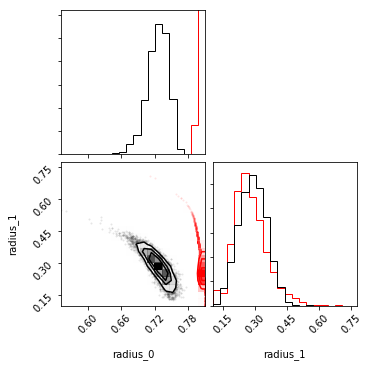

In [7]:
import numpy as np

def compare_radii(mod, R1, R2):
    samples1 = np.array([R1, R2]).T
    samples2 = mod.derived_samples[['radius_0', 'radius_1']]
    
    param_range = [(min(min(R1), samples2.radius_0.min()), max(max(R1), samples2.radius_0.max())),
                   (min(min(R2), samples2.radius_1.min()), max(max(R2), samples2.radius_0.max()))]

    fig = corner(samples1, range=param_range, color='red')
    return corner(samples2, fig=fig, range=param_range)

compare_radii(mod, R1, R2);

OK, let's ask a more specific question.  For each sample here (representing a fixed value of $f_{EB}$), how much is the estimate of the radius ratio $R_2/R_1$ biased with respect to the "true" value?

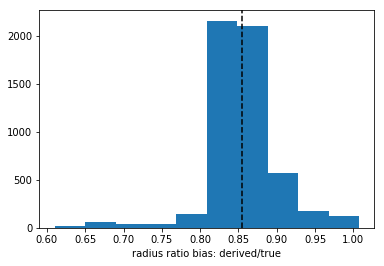

In [21]:
import matplotlib.pyplot as plt

def bias_hist(mod, R1, R2):
    R2R1_iso = mod.derived_samples.radius_1 / mod.derived_samples.radius_0
    R2R1_tri = np.array(R2)/np.array(R1)

    bias = R2R1_tri / R2R1_iso
    plt.hist(bias);
    plt.axvline(bias.mean(), color='k', ls='--')
    plt.xlabel('radius ratio bias: derived/true')
    
bias_hist(mod, R1, R2)

OK, so for this particular star, the estimated radius ratio tends to be off by about 15% from the truth.  So the question remains: does this matter?  

Well, the TRICERATOPS algorithm computes the EB light curve as a function of $f_{EB}$ and looks for the value of $f_{EB}$ that gives the best fit to the data.  I think this bias should then not affect the actual maximum likelihood value (the most important number for FPP analysis), but rather that the actual computed *value* of the radius ratio $at$ the max-likelihood value of $f_{EB}$ will be biased by about this much.  

However, one thing that perhaps should be different if we wanted to properly take into account the fact that we know the color of the target star, would be the prior on $f_{EB}$.  Here's the distribution of $f_{EB}$ allowed by the color constraint: 

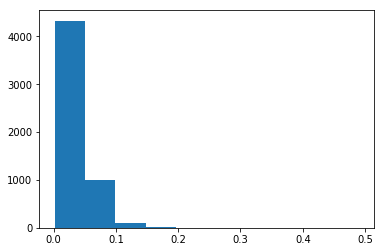

In [10]:
plt.hist(f_EB);

This is fairly different from assuming a flat prior on $f_{EB}$, though this will probably only matter in borderline cases, i.e., where the max-likelihood of EB model is close to that of the TP model.

Now remember, this was all done in the context of the true simulated star actually being a single star, meaning all the purported binary companions are forced toward low masses.  Is this any different if the true scenario is actually a more luminous binary?

## Pt 2: binary simulation

Here, we do the same as above, but generate properties of a binary star instead of a single star 

In [11]:
mass1, mass2, age, feh = (1.0, 0.6, 9.7, 0.0)
distance = 10  # pc
AV = 0.0

simulated_props_2 = mist.generate_binary(mass1, mass2, age, feh)

In [12]:
props = {'V': (float(simulated_props_2['V_mag']), 0.02), 'K': (float(simulated_props_2['K_mag']), 0.02), 'parallax': (100, 0.05)}

mod_2 = BinaryStarModel(mist, **props, maxAV=0.0001, eep_bounds=(0, 450), name='triceratops_eb_2')

In [13]:
mod_2.fit()

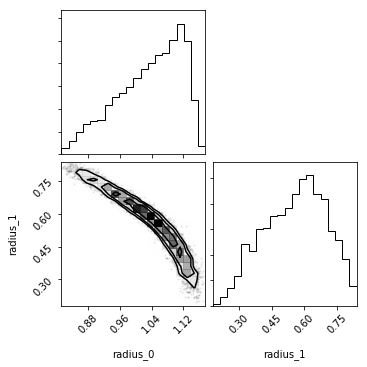

In [14]:
corner(mod_2.derived_samples[['radius_0', 'radius_1']]);

In [15]:
dmag_2 = mod_2.derived_samples['TESS_mag_1'] - mod_2.derived_samples['TESS_mag_0']
f_ratio_2 = 10**(-0.4 * dmag_2)
f_EB_2 = 1 / (1./f_ratio_2 + 1)

L_tot = float(10**simulated_props_2['logL_0'] + 10**simulated_props_2['logL_1'])
R1_2, R2_2 = zip(*[get_radii(L_tot, f) for f in f_EB_2])

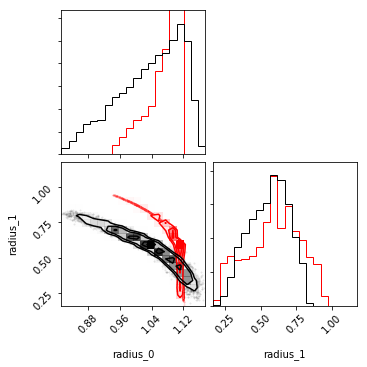

In [16]:
compare_radii(mod_2, R1_2, R2_2);

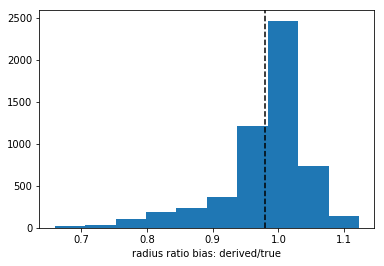

In [22]:
bias_hist(mod_2, R1_2, R2_2)

And here, in a case where the system actually is a binary, there seems to be even less of a systematic bias, 